## Spiral experiment

In [1]:
import ipyexperiments

In [2]:
import gc

In [3]:
import numpy as np
import sklearn.datasets as datasets
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
import torch.utils.data as data_utils
from torchdiffeq import odeint, odeint_adjoint

# nome che fa figo
from torchcontrol.arch_cpugpu import HDNN
from torchcontrol.predictors import MLP, CNN
from torchcontrol.utils import genpoints, dump_tensors

In [4]:
np.random.seed(10)

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [6]:
for obj in gc.get_objects():
    try:
        if torch.is_tensor(obj) or (hasattr(obj, 'data') and torch.is_tensor(obj.data)):
            print(type(obj), obj.size())
    except: pass

In [7]:
dump_tensors()

Total size: 0


In [8]:
def twospirals(n_points, noise=.5):
    """
     Returns the two spirals dataset.
    """
    n = np.sqrt(np.random.rand(n_points,1)) * 780 * (2*np.pi)/360
    d1x = -np.cos(n)*n + np.random.rand(n_points,1) * noise
    d1y = np.sin(n)*n + np.random.rand(n_points,1) * noise
    return (np.vstack((np.hstack((d1x,d1y)),np.hstack((-d1x,-d1y)))), 
            np.hstack((np.zeros(n_points),np.ones(n_points))))

### Data generation

In [9]:
data = 'spirals'

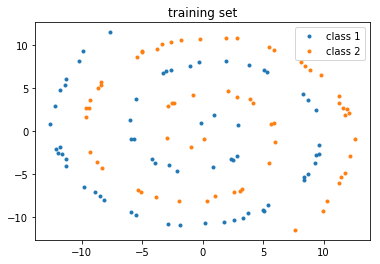

In [10]:
if data == 'blobs':
    X,yn = datasets.make_blobs(n_samples=64, centers = 2,n_features=2)
    plt.scatter(X[yn==1,0],X[yn==1,1],color='blue')
    plt.scatter(X[yn==0,0],X[yn==0,1],color='red')
if data == 'moons':
    X, yn = datasets.make_moons(n_samples=10)
    plt.scatter(X[yn==1,0],X[yn==1,1],color='blue')
    plt.scatter(X[yn==0,0],X[yn==0,1],color='red')
if data == 'mclass':
    X, yn = datasets.make_classification(n_samples=500,n_informative=4,n_clusters_per_class=3,n_classes=3)
    plt.scatter(X[yn==1,0],X[yn==1,1],color='blue')
    plt.scatter(X[yn==0,0],X[yn==0,1],color='red')
    plt.scatter(X[yn==2,0],X[yn==2,1],color='green')
if data == 'spirals':
    X, yn = twospirals(64)
    plt.title('training set')
    plt.plot(X[yn==0,0], X[yn==0,1], '.', label='class 1')
    plt.plot(X[yn==1,0], X[yn==1,1], '.', label='class 2')
    plt.legend()

In [11]:
one_hot_yn = [[1,0] if l == 0 else [0,1] for l in yn]

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, yn, test_size=0.1)

In [13]:
# choose batch size here
bs = 64

X_train = torch.Tensor(X_train).to(device)
y_train = torch.LongTensor(y_train).to(device)
X_test = torch.Tensor(X_test).to(device)
y_test = torch.LongTensor(y_test).to(device)

train = data_utils.TensorDataset(X_train,y_train)
trainloader = data_utils.DataLoader(train, batch_size=bs, shuffle=True)

test = data_utils.TensorDataset(X_test,y_test)
testloader = data_utils.DataLoader(test, batch_size=bs, shuffle=True)

## Learning a boundary in R2

-  HDNN wrapper is initialized with a predictor (also nn.Module) as input that is used during inference and the parameters of which are updated according to hamiltonian dynamics. The default fully connected network class is given as a baseline. 
-  NOTE: Bigger nets might require high amounts of CUDA memory and might thus crash. Further optimization is required

In [14]:
exp1 = ipyexperiments.IPyExperimentsPytorch()


*** Experiment started with the Pytorch backend
Device: ID 0, GeForce GTX 1060 3GB (3072 RAM)


*** Current state:
RAM:  Used  Free  Total      Util
CPU:  1175 12225  16304 MB   7.21% 
GPU:   680  2391   3072 MB  22.14% 


･ RAM: △Consumed △Peaked  Used Total | Exec time 0:00:00.000
･ CPU:         0       0     1175 MB |
･ GPU:         0       0      680 MB |


In [15]:
class MLPBN(nn.Module):
    def __init__(self, dense_layers, softmax = True):
        '''
        Simple dense MLP class used as predictor for HDNN
        
        :smax_l: leave True for softmax applied to ouput
        '''
        super().__init__()
        self.dense_layers = nn.ModuleList([nn.Linear(dense_layers[i], dense_layers[i + 1]) \
                                           for i in range(len(dense_layers) - 1)])
        self.softmax = softmax
        
    def getLength(self):
        return len(self.dense_layers)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        for l in self.dense_layers:
            l_x = l(x)
            #x = nn.BatchNorm1d(x.size(1)).to(device)(x)
            x = F.relu(l_x)
        if not self.softmax: return l_x
        else: return F.log_softmax(l_x, dim=1)

･ RAM: △Consumed △Peaked  Used Total | Exec time 0:00:00.002
･ CPU:         0       0     1175 MB |
･ GPU:         3       0      683 MB |


In [40]:
# example: [2,12,2] are the dense layers of the MLP predictor used, \
# whereas [1,2,0] are the a,b,c of the loss function. 2 is beta 
m = HDNN('MLPBN',[[2,36,36,36,36,2]],[1,0.005,0],3,p_module=__name__,odeint='cpu').to(device)

･ RAM: △Consumed △Peaked  Used Total | Exec time 0:00:00.012
･ CPU:         1       0     1596 MB |
･ GPU:        -1       0      722 MB |


In [41]:
print('Initial accuracy on training dataset: {} %'.format(m.pred_accuracy(trainloader)))

Initial accuracy on training dataset: 0.5130434782608696 %
･ RAM: △Consumed △Peaked  Used Total | Exec time 0:00:00.023
･ CPU:         0       0     1596 MB |
･ GPU:        29       0      751 MB |


In [65]:
m.fit(trainloader,1000,tplot=50,iter_accuracy=float('inf'),ode_t=0.1,ode_step=2,criterion='nll')

odeint iter: 44550 
odeint iter: 44600 
odeint iter: 44650 
odeint iter: 44700 
odeint iter: 44750 
odeint iter: 44800 
odeint iter: 44850 
odeint iter: 44900 
odeint iter: 44950 
odeint iter: 45000 
odeint iter: 45050 
odeint iter: 45100 
odeint iter: 45150 
odeint iter: 45200 
odeint iter: 45250 
odeint iter: 45300 
odeint iter: 45350 
odeint iter: 45400 
odeint iter: 45450 
odeint iter: 45500 
odeint iter: 45550 
odeint iter: 45600 
odeint iter: 45650 
odeint iter: 45700 
odeint iter: 45750 
odeint iter: 45800 
odeint iter: 45850 
odeint iter: 45900 
odeint iter: 45950 
odeint iter: 46000 
odeint iter: 46050 
odeint iter: 46100 
odeint iter: 46150 
odeint iter: 46200 
odeint iter: 46250 
odeint iter: 46300 
odeint iter: 46350 
odeint iter: 46400 
odeint iter: 46450 
odeint iter: 46500 
odeint iter: 46550 
odeint iter: 46600 
odeint iter: 46650 
odeint iter: 46700 
odeint iter: 46750 
odeint iter: 46800 
odeint iter: 46850 
odeint iter: 46900 
odeint iter: 46950 
odeint iter: 47000 


odeint iter: 65050 
odeint iter: 65100 
odeint iter: 65150 
odeint iter: 65200 
odeint iter: 65250 
odeint iter: 65300 
odeint iter: 65350 
odeint iter: 65400 
odeint iter: 65450 
odeint iter: 65500 
odeint iter: 65550 
odeint iter: 65600 
odeint iter: 65650 
odeint iter: 65700 
odeint iter: 65750 
odeint iter: 65800 
odeint iter: 65850 
odeint iter: 65900 
odeint iter: 65950 
odeint iter: 66000 
odeint iter: 66050 
odeint iter: 66100 
odeint iter: 66150 
odeint iter: 66200 
odeint iter: 66250 
odeint iter: 66300 
odeint iter: 66350 
odeint iter: 66400 
odeint iter: 66450 
odeint iter: 66500 
odeint iter: 66550 
odeint iter: 66600 
odeint iter: 66650 
odeint iter: 66700 
odeint iter: 66750 
odeint iter: 66800 
odeint iter: 66850 
odeint iter: 66900 
odeint iter: 66950 
odeint iter: 67000 
odeint iter: 67050 
odeint iter: 67100 
odeint iter: 67150 
odeint iter: 67200 
odeint iter: 67250 
odeint iter: 67300 
odeint iter: 67350 
odeint iter: 67400 
odeint iter: 67450 
odeint iter: 67500 


In [66]:
print('Post-training accuracy on test dataset: {} '.format(m.pred_accuracy(testloader)))

Post-training accuracy on test dataset: 0.7692307692307693 
･ RAM: △Consumed △Peaked  Used Total | Exec time 0:00:00.053
･ CPU:         0       0    11114 MB |
･ GPU:       -22       8      702 MB |


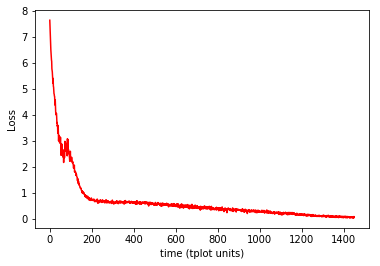

･ RAM: △Consumed △Peaked  Used Total | Exec time 0:00:00.433
･ CPU:         0       0    10149 MB |
･ GPU:         7       0      710 MB |


In [67]:
m.plotLoss()

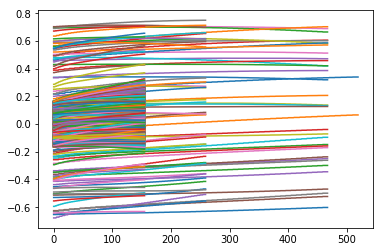

･ RAM: △Consumed △Peaked  Used Total | Exec time 0:00:12.679
･ CPU:         0      63     2029 MB |
･ GPU:        -8      33      706 MB |


In [45]:
m.plotParameters()

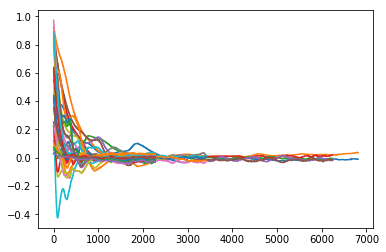

･ RAM: △Consumed △Peaked  Used Total | Exec time 0:00:00.587
･ CPU:         0       9     1588 MB |
･ GPU:        -2       0      700 MB |


In [35]:
m.plotVelocities()

## Create boundary plot

In [68]:
mp = genpoints(-12,12,-12,12,100)

･ RAM: △Consumed △Peaked  Used Total | Exec time 0:00:00.099
･ CPU:         0       2    10151 MB |
･ GPU:        38       0      749 MB |


In [69]:
y,idx = torch.max(torch.exp(m.predictor.forward(mp)),1)

･ RAM: △Consumed △Peaked  Used Total | Exec time 0:00:00.017
･ CPU:         0       0    10151 MB |
･ GPU:        -1      20      747 MB |


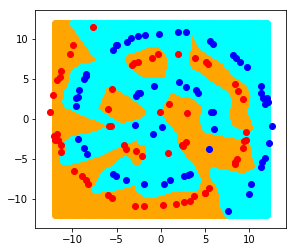

･ RAM: △Consumed △Peaked  Used Total | Exec time 0:00:00.355
･ CPU:         0       0    10152 MB |
･ GPU:         5       3      752 MB |


In [70]:
mp_r = mp[idx==0]
mp_b = mp[idx==1]
plt.figure(figsize=(4.5,4))
plt.scatter(mp_r[:,0].cpu(),mp_r[:,1].cpu(),color='orange')
plt.scatter(mp_b[:,0].cpu(),mp_b[:,1].cpu(),color='cyan')
plt.scatter(X[yn==1,0],X[yn==1,1],color='blue')
plt.scatter(X[yn==0,0],X[yn==0,1],color='red')

In [26]:
del exp1

･ RAM: △Consumed △Peaked  Used Total | Exec time 0:00:00.000
･ CPU:         0       0     1317 MB |
･ GPU:         0       0     1953 MB |

IPyExperimentsPytorch: Finishing

*** Experiment finished in 00:01:39 (elapsed wallclock time)

*** Newly defined local variables:
Deleted: MLPBN, idx, m, mp, mp_b, mp_r, y

*** Circular ref objects gc collected during the experiment:
cleared 16 objects (only temporary leakage)

*** Experiment memory:
RAM:  Consumed     Reclaimed
CPU:     142       0 MB (  0.08%)
GPU:      53       4 MB (  7.51%)

*** Current state:
RAM:  Used  Free  Total      Util
CPU:  1317  5823  16304 MB   8.08% 
GPU:  1949  1122   3072 MB  63.44% 




## Series of experiments with varying beta

note: with low beta it takes way longer to integrate

In [15]:
def obtain_plot(bhsh, n=10):
    pl = {}
    for i in range(n):
        m = HDNN([2,8,8,2],'MLP',[1,3,0.01],bhsh[i],odeint='cpu').cuda()
        m.fit(trainloader,1,time_delta=10,iter_accuracy=10,ode_t=20,ode_step=20)
        pl[i] = m.predictor
        del m
    return pl

･ RAM: △Consumed △Peaked  Used Total | Exec time 0:00:00.075
･ CPU:         0       2     1469 MB |
･ GPU:        -9       0     1443 MB |


In [16]:
p = []
bhsh = {0:0,1:0.02,2:0.04,3:0.06,4:0.08,5:1,6:1.2,7:1.4,8:1.6,9:1.8}
p = obtain_plot(bhsh, 10)

odeint iter: 10 
odeint iter: 20 
odeint iter: 30 
odeint iter: 40 
odeint iter: 50 
odeint iter: 60 
odeint iter: 70 
odeint iter: 80 
odeint iter: 90 
odeint iter: 100 
odeint iter: 110 
odeint iter: 120 
odeint iter: 130 
odeint iter: 140 
odeint iter: 150 
odeint iter: 160 
odeint iter: 170 
odeint iter: 180 
odeint iter: 190 
odeint iter: 200 
odeint iter: 210 
odeint iter: 220 
odeint iter: 230 
odeint iter: 240 
odeint iter: 250 
odeint iter: 260 
odeint iter: 270 
odeint iter: 280 
odeint iter: 290 
odeint iter: 300 
odeint iter: 310 
odeint iter: 320 
odeint iter: 330 
odeint iter: 340 
odeint iter: 350 
odeint iter: 360 
odeint iter: 370 
odeint iter: 380 
odeint iter: 390 
odeint iter: 400 
odeint iter: 410 
odeint iter: 420 
odeint iter: 430 
odeint iter: 440 
odeint iter: 450 
odeint iter: 460 
odeint iter: 470 
odeint iter: 480 
odeint iter: 490 
odeint iter: 500 
  message: 'The solver successfully reached the end of the integration interval.'
     nfev: 506
     njev: 0

odeint iter: 40 
odeint iter: 50 
odeint iter: 60 
odeint iter: 70 
odeint iter: 80 
odeint iter: 90 
odeint iter: 100 
odeint iter: 110 
odeint iter: 120 
odeint iter: 130 
odeint iter: 140 
odeint iter: 150 
odeint iter: 160 
odeint iter: 170 
odeint iter: 180 
odeint iter: 190 
odeint iter: 200 
odeint iter: 210 
odeint iter: 220 
odeint iter: 230 
odeint iter: 240 
odeint iter: 250 
odeint iter: 260 
odeint iter: 270 
odeint iter: 280 
odeint iter: 290 
odeint iter: 300 
odeint iter: 310 
odeint iter: 320 
odeint iter: 330 
odeint iter: 340 
odeint iter: 350 
odeint iter: 360 
odeint iter: 370 
odeint iter: 380 
odeint iter: 390 
odeint iter: 400 
odeint iter: 410 
  message: 'The solver successfully reached the end of the integration interval.'
     nfev: 410
     njev: 0
      nlu: 0
      sol: None
   status: 0
  success: True
        t: array([0.        , 0.00969928, 0.03942022, 0.09498556, 0.2152554 ,
       0.27480877, 0.30891703, 0.34599528, 0.36800812, 0.39002095,
       0.

･ RAM: △Consumed △Peaked  Used Total | Exec time 0:00:14.480
･ CPU:         0       8     1500 MB |
･ GPU:         7       0     1451 MB |


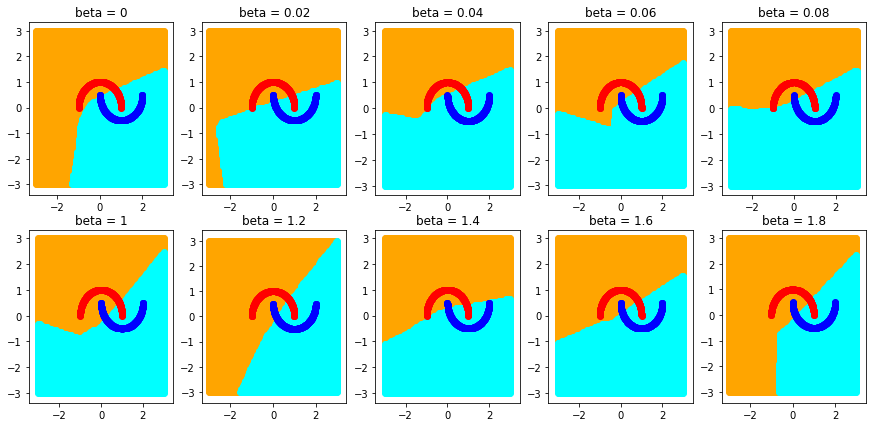

･ RAM: △Consumed △Peaked  Used Total | Exec time 0:00:02.674
･ CPU:         0       7     1438 MB |
･ GPU:         2       0     1438 MB |


In [28]:
plt.figure(figsize=(15,7))
mp = genpoints(-3,3,-3,3,100)
for i in range(10):    
    y,idx = torch.max(torch.exp(p[i].forward(mp)),1)
    mp_r = mp[idx==0]
    mp_b = mp[idx==1]
    plt.subplot(2, 5, i+1)
    plt.scatter(mp_r[:,0].cpu(),mp_r[:,1].cpu(),color='orange')
    plt.scatter(mp_b[:,0].cpu(),mp_b[:,1].cpu(),color='cyan')
    plt.scatter(X[yn==1,0],X[yn==1,1],color='blue')
    plt.scatter(X[yn==0,0],X[yn==0,1],color='red')
    plt.title('beta = {}'.format(bhsh[i]))

## Varying b

where b is coeff. of $$||\dot{\omega}||^{2}$$

notes: why does int. time change as b changes?

In [63]:
def obtain_plot(bhsh, n=10):
    pl = {}
    for i in range(n):
        m = HDNN([2,8,8,8,2],'MLP',[1,bhsh[i],0.01],1,odeint='cpu').cuda()
        m.fit(trainloader,2,time_delta=None,iter_accuracy=10,ode_t=50,ode_step=2)
        pl[i] = m.predictor
        del m
    return pl

･ RAM: △Consumed △Peaked  Used Total | Exec time 0:00:00.001
･ CPU:         0       0     1473 MB |
･ GPU:        -3       0     1614 MB |


In [59]:
p = []
bhsh = {0:0.5,1:1,2:1.5,3:2,4:2.5,5:3,6:3.5,7:4,8:4.5,9:5}
p = obtain_plot(bhsh, 10)

  message: 'The solver successfully reached the end of the integration interval.'
     nfev: 8
     njev: 0
      nlu: 0
      sol: None
   status: 0
  success: True
        t: array([0.      , 0.010005])
 t_events: None
        y: array([[ 1.87005222e-01,  1.95009494e-01],
       [-6.03262901e-01, -6.02885683e-01],
       [ 5.21944463e-01,  5.25562367e-01],
       [-1.97260916e-01, -1.95546531e-01],
       [ 5.31345785e-01,  5.40407069e-01],
       [-3.40312034e-01, -3.38810373e-01],
       [ 1.48828804e-01,  1.54910913e-01],
       [-4.91276383e-01, -4.87481463e-01],
       [ 3.02844703e-01,  3.06917036e-01],
       [-1.58596575e-01, -1.49093078e-01],
       [ 1.69050753e-01,  1.74080253e-01],
       [-4.58304316e-01, -4.50121157e-01],
       [ 6.84011579e-02,  7.22906628e-02],
       [-4.04138118e-01, -4.01429601e-01],
       [ 6.05556369e-02,  6.59938039e-02],
       [ 1.21372104e-01,  1.24389860e-01],
       [-5.41842639e-01, -5.39189322e-01],
       [-5.70270777e-01, -5.69116212e

odeint iter: 10 
  message: 'The solver successfully reached the end of the integration interval.'
     nfev: 14
     njev: 0
      nlu: 0
      sol: None
   status: 0
  success: True
        t: array([0.        , 0.00784036, 0.010005  ])
 t_events: None
        y: array([[ 0.25948381,  0.28335346,  0.28981243],
       [ 0.53814441,  0.53985122,  0.54031308],
       [-0.4787854 , -0.45779784, -0.45211868],
       ...,
       [ 0.58376688,  0.56567177,  0.56077486],
       [ 0.40105653,  0.38801232,  0.38448303],
       [ 0.27915621,  0.27101988,  0.26881583]])
odeint iter: 10 
  message: 'The solver successfully reached the end of the integration interval.'
     nfev: 14
     njev: 0
      nlu: 0
      sol: None
   status: 0
  success: True
        t: array([0.        , 0.00774443, 0.010005  ])
 t_events: None
        y: array([[ 5.62289059e-01,  5.89253037e-01,  5.96928458e-01],
       [-6.86401129e-03, -5.24611683e-04,  1.27935810e-03],
       [ 1.46195114e-01,  1.64182121e-01,  1.69

  message: 'The solver successfully reached the end of the integration interval.'
     nfev: 14
     njev: 0
      nlu: 0
      sol: None
   status: 0
  success: True
        t: array([0.        , 0.00385703, 0.010005  ])
 t_events: None
        y: array([[-0.57563305, -0.55431488, -0.52166294],
       [ 0.10263985,  0.12187284,  0.1513342 ],
       [-0.26194394, -0.24088989, -0.20863918],
       ...,
       [ 0.81550711,  0.79072448,  0.75276689],
       [ 0.72022331,  0.6986081 ,  0.66545851],
       [ 0.86155564,  0.83517198,  0.79480095]])
odeint iter: 10 
  message: 'The solver successfully reached the end of the integration interval.'
     nfev: 14
     njev: 0
      nlu: 0
      sol: None
   status: 0
  success: True
        t: array([0.        , 0.00727956, 0.010005  ])
 t_events: None
        y: array([[0.70608908, 0.74349114, 0.7568742 ],
       [0.27217942, 0.31981676, 0.33686225],
       [0.17843115, 0.20826532, 0.21893866],
       ...,
       [0.60004717, 0.56206537, 0.548

･ RAM: △Consumed △Peaked  Used Total | Exec time 0:00:01.010
･ CPU:         0       0     1471 MB |
･ GPU:         4       0     1621 MB |


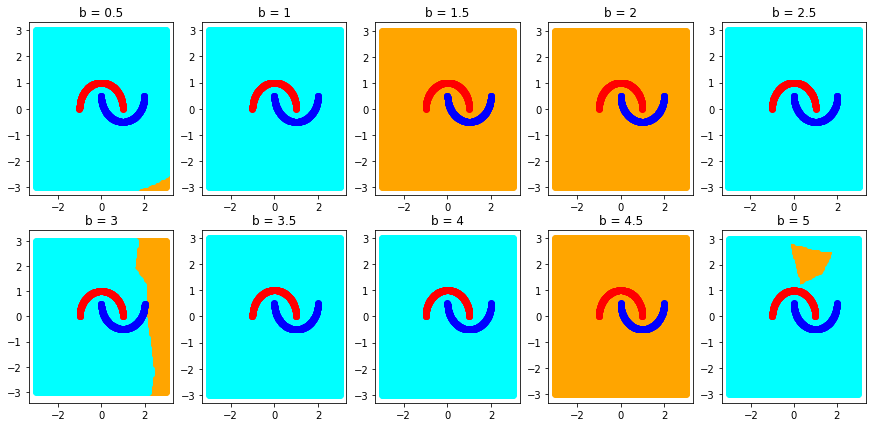

･ RAM: △Consumed △Peaked  Used Total | Exec time 0:00:02.755
･ CPU:         0       7     1473 MB |
･ GPU:         3       0     1625 MB |


In [60]:
plt.figure(figsize=(15,7))
mp = genpoints(-3,3,-3,3,100)
for i in range(10):    
    y,idx = torch.max(torch.exp(p[i].forward(mp)),1)
    mp_r = mp[idx==0]
    mp_b = mp[idx==1]
    plt.subplot(2, 5, i+1)
    plt.scatter(mp_r[:,0].cpu(),mp_r[:,1].cpu(),color='orange')
    plt.scatter(mp_b[:,0].cpu(),mp_b[:,1].cpu(),color='cyan')
    plt.scatter(X[yn==1,0],X[yn==1,1],color='blue')
    plt.scatter(X[yn==0,0],X[yn==0,1],color='red')
    plt.title('b = {}'.format(bhsh[i]))